In [1]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from Full_model import Integrated_Model

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

name: X_test
shape: (640, 35, 2649)
-----------------------
name: X_train
shape: (640, 35, 2564)
-----------------------
name: clip_sizes_test
shape: (2, 102)
-----------------------
name: clip_sizes_train
shape: (2, 101)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 2649)
-----------------------
name: sel_win_nums_train
shape: (1, 2564)
-----------------------
name: soz_ch_ids
shape: (7, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 2649)
-----------------------
name: y_train
shape: (1, 2564)
-----------------------
print sample EGG signal from one node:


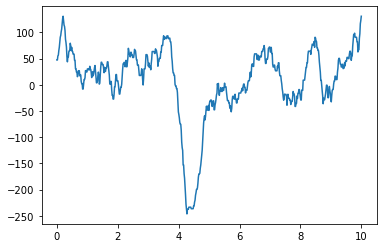

In [2]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_273.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [3]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [4]:
#reduce redundant nodes
#from DataManager import get_label_variance as glv
#print(glv(dm.X_train, dm.Y_train))
#print(np.argsort(glv(dm.X_train, dm.Y_train)))
print(dm)
#dm.apply_dvariance_filter(30)
#dm.mean_pooling_1d(size = 15, stride = 13, padding = 0)
print(dm)

X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)
X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)


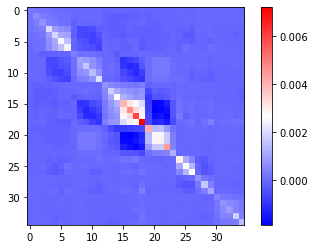

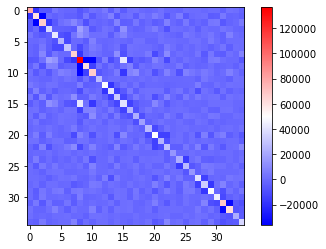

In [5]:
show_heat_map(dm.P_avg_train)
show_heat_map(dm.conv_avg_train)

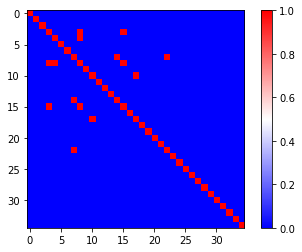

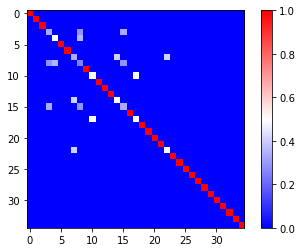

In [6]:
# adjacency generated by convariance
A2 = (dm.conv_avg_train > 10000)# + (dm.conv_avg_train < -8000) 
show_heat_map(A2)
show_heat_map(create_DAD(A2))

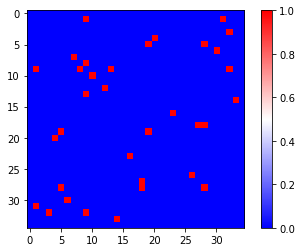

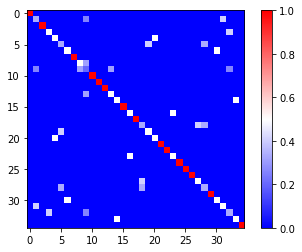

In [7]:
#randomly generated A
b = np.random.randint(-2000,2000,size=dm.conv_avg_train.shape)
A3 = (b + b.T)/2 > 1500
show_heat_map(A3)
show_heat_map(create_DAD(A3))

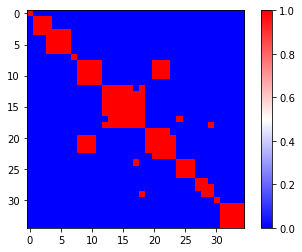

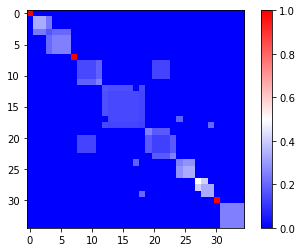

In [11]:
n = 2.5*10**-4
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train#A3#A2 #dm.A_train

In [44]:
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 512,
    'n_layers': 2,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.EF
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,1], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1, 64], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
#print(GCNparameters['M'])

In [45]:
IM = Integrated_Model(GCNparameters, GDEparameters, MLPparametersGCN, MLPparametersGDE, dm, Araw)

  0%|          | 0/3 [00:00<?, ?it/s]

----------Training GCN-----------
device set to cpu


 33%|███▎      | 1/3 [00:01<00:02,  1.16s/it]

 67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1   Batch: 3 of size 512   Train loss: 41.496925354003906   Valid loss: 22.129175186157227
----------Training Ends-----------
----------Training GDE-----------
device set to cpu


  9%|▉         | 1/11 [00:01<00:19,  1.97s/it]

 18%|█▊        | 2/11 [00:03<00:17,  1.98s/it]

 27%|██▋       | 3/11 [00:06<00:15,  2.00s/it]

 36%|███▋      | 4/11 [00:08<00:14,  2.02s/it]

 45%|████▌     | 5/11 [00:10<00:12,  2.04s/it]

 55%|█████▍    | 6/11 [00:12<00:10,  2.04s/it]

 64%|██████▎   | 7/11 [00:14<00:08,  2.03s/it]

 73%|███████▎  | 8/11 [00:16<00:06,  2.02s/it]

 82%|████████▏ | 9/11 [00:18<00:04,  2.04s/it]

 91%|█████████ | 10/11 [00:20<00:02,  2.03s/it]

100%|██████████| 11/11 [00:21<00:00,  2.00s/it]

Epoch: 1   Batch: 11 of size 128   Train loss: 0.9091485738754272   Valid loss: 0.8614563941955566
----------Training Ends-----------


----------Training MLP-----------
0.446 ----------saved-----------
0.484 ----------saved-----------
0.51 ----------saved-----------
0.518 ----------saved-----------
0.524 ----------saved-----------
0.539 ----------saved-----------
0.344 ----------saved-----------
0.38 ----------saved-----------
0.39 ----------saved-----------
0.445 ----------saved-----------
0.474 ----------saved-----------
0.487 ----------saved-----------
0.5 ----------saved-----------
0.531 ----------saved-----------
0.547 ----------saved-----------
0.553 ----------saved-----------
0.556 ----------saved-----------
0.564 ----------saved-----------
----------Training Ends-----------


GCN accuracy:
device set to cuda
threshold: 0.05  validation loss: 0.35 F1 accuracy 0.472 Precision accuracy 0.344 Recall accuracy 0.747 AUC accuracy: 0.823
device set to cuda
threshold: 0.1  validation loss: 0.35 F1 accuracy 0.496 Precision accuracy 0.405 Recall accuracy 0.639 AUC accuracy: 0.823
device set to cuda
threshold: 0.15  validation loss: 0.35 F1 accuracy 0.523 Precision accuracy 0.467 Recall accuracy 0.593 AUC accuracy: 0.823
device set to cuda
threshold: 0.2  validation loss: 0.35 F1 accuracy 0.529 Precision accuracy 0.495 Recall accuracy 0.567 AUC accuracy: 0.823
device set to cuda
threshold: 0.25  validation loss: 0.35 F1 accuracy 0.539 Precision accuracy 0.533 Recall accuracy 0.546 AUC accuracy: 0.823
device set to cuda
threshold: 0.3  validation loss: 0.35 F1 accuracy 0.519 Precision accuracy 0.539 Recall accuracy 0.5 AUC accuracy: 0.823
device set to cuda
threshold: 0.35  validation loss: 0.35 F1 accuracy 0.504 Precision accuracy 0.56 Recall accuracy 0.459 AUC accurac

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


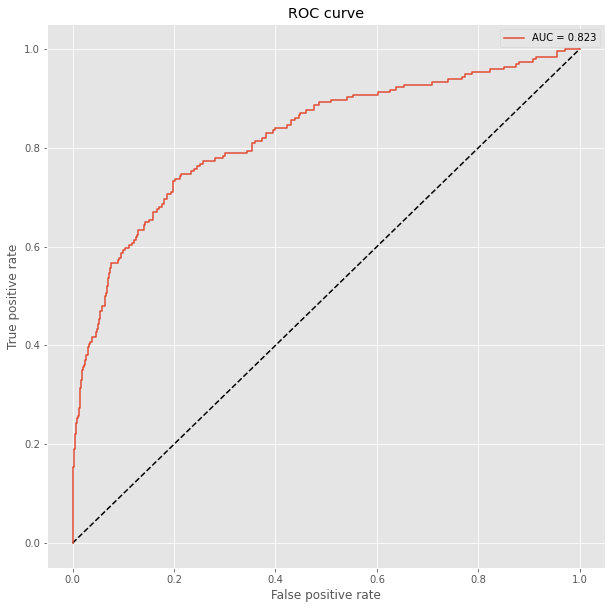

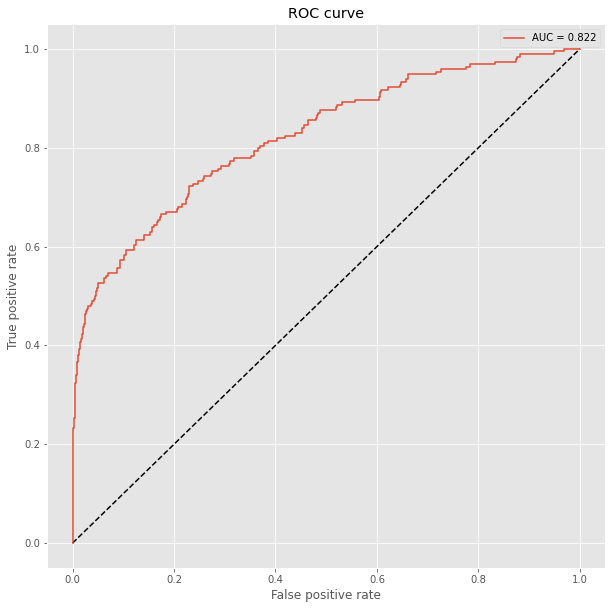

In [46]:
IM.print_accuracy(dm, Araw, device_name = 'cpu')